***
# Easy Cash - Credit Risk Classification
Uma das área que causa mais problemas para bancos, financiadoras e empresários é a taxa de inadimplência por parte da sua carteira de clientes. Avaliar se uma pessoa irá deixar de cumprir com suas obrigações financeiras é de extrema importância, e pode causar um grande impacto no balanço da Instituição. Cada vez mais soluções vêm sendo desenvolvidas e aprimoradas visando minimizar o ***risco de default***.

#### Definições
***Defaulf:*** é o termo utilizado para indicar o não cumprimento das obrigações e/ou condições de um empréstimo (como financiamentos ou dívidas de cartão de crédito)


***Expected Loss =  PD * EAD * LGD***, onde:
- ***Probability Default (PD)*** → Probabilidade de inadimplência , que é a probabilidade de alguém deixar de pagar um empréstimo
- ***Exposure at Default (EAD)*** → A Exposição á inadimplência, que é o valor em aberto no momento da inadimplência
- ***Loss Given Default (LGD)*** → E a perda dada a inadimplência que é a razão da exposição contra qualquer recuperação da perda


***

## 2. DATA UNDERSTANDING

A base de dados foi disponibilizada pelo cliente em 4 tabelas distintas (descritas abaixo) no formato de dumps (.sql), os dados das tabelas foram carregados no banco de dados ` analise_risco` no MySQL, posteriormente foi realizado o ***union data*** consolidando os dados em apenas uma tabela `dados_juntos.csv` exportado em formato .csv para consumo.

Para consultar o dicionário de dados , consulte o readme: `/data/readme.md`

### 2.0 IMPORTING LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('figure', figsize = (12,6))
%matplotlib inline

### 2.1 LOADING DATA

In [4]:
dados = pd.read_csv('../data/raw/dados_unidos.csv')
dados.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21.0,60000.0,Rent,2.0,Education,B,8000.0,11.26,0.0,0.13,N,3.0
1,40.0,70000.0,Mortgage,6.0,Education,A,18000.0,7.90,0.0,0.26,N,14.0
2,29.0,115000.0,Mortgage,3.0,Medical,C,22000.0,15.23,0.0,0.19,Y,7.0
3,26.0,84996.0,Rent,0.0,Medical,B,9000.0,11.26,0.0,0.11,N,2.0
4,23.0,54500.0,Rent,2.0,Debtconsolidation,A,8000.0,NaN,0.0,0.15,N,2.0


In [5]:
# Verificando a qtd de registros
print(f'Número de Registros: {dados.shape[0]}')
print(f'Número de Colunas: {dados.shape[1]}')

Número de Registros: 34501
Número de Colunas: 12


### 2.2 RENAMING COLUMNS E DATA

In [6]:
# Renomeando nomes das colunas - tradução (en -> pt)
dict_col_name = {
    'person_age': 'idade_usuario',
    'person_income': 'salario_usuario',
    'person_home_ownership': 'situacao_moradia_usuario',
    'person_emp_length': 'tempo_de_trabalho_usuario',
    'loan_intent': 'motivo_emprestimo',
    'loan_grade': 'pontuacao_emprestimo',
    'loan_amnt': 'valor_emprestimo',
    'loan_int_rate': 'taxa_juros_emprestimo',
    'loan_status': 'status_emprestimo',
    'loan_percent_income': 'renda_percentual_emprestimo',
    'cb_person_default_on_file': 'devendo',
    'cb_person_cred_hist_length': 'tempo_de_credito'
}
# axis=1 -> coluna
dados.rename(dict_col_name, axis= 1, inplace=True)

In [7]:
# Renomeando dados das linhas - tradução (en -> pt)
dict_situacao_moradia = {
    'Rent': 'Alugada',
    'Own': 'Propria',
    'Mortgage': 'Hipotecada',
    'Other': 'Outros'
}

dict_motivo_emprestimo = {
    'Personal':'Pessoal',
    'Education': 'Educativo',
    'Medical':'Medico',
    'Venture':'Empreendimento',
    'Homeimprovement': 'Melhoria do Lar',
    'Debtconsolidation': 'Pagamento de Debitos'
}
# axis=0 (default) -> linhas
dados.replace(dict_situacao_moradia, inplace=True)
dados.replace(dict_motivo_emprestimo, inplace=True)

### 2.3 CLEANING DATA


Sabemos que boa parte do tempo e sucesso de um projeto de Machine Learning concentrasse na limpeza dos dados, os dados preparados permitem que os modelos treinem mais rapidamente, além de impactar significativamente o desempenho do modelo, desta forma será garantido a qualidade da base de dados, tratando valores ausentes, nulos e remoção de outliers.

### i) Missing Data

In [8]:
# Verificando a presença de valores nulos
dados.isnull().sum()

idade_usuario                   324
salario_usuario                 339
situacao_moradia_usuario        331
tempo_de_trabalho_usuario      1254
motivo_emprestimo               315
pontuacao_emprestimo            313
valor_emprestimo                331
taxa_juros_emprestimo          3630
status_emprestimo               343
renda_percentual_emprestimo     319
devendo                         370
tempo_de_credito                  4
dtype: int64

**NOTAS:** É possível verificar que há dados nulos/ausentes em todas as categorias sejam de dados númericos ou categóricos, que precisam ser tratados. 

##### DROPNA( ) - Removendo dados ausentes
a) `status_emprestimo`: Os dados ausentes na nossa variável default `status_emprestimo` não poderá ser utilizado para prever a probabilidade de inadimplência, porque não saberemos se o empréstimo foi inadimplente ou não, além de se tratar da resposta que procuramos da variável dependente.

b) `taxa_juros_emprestimo`: De forma semelhante ao item anterior, ter dados ausentes neste campo dificultará as previsões do modelo. Como as taxas de juros são definidas pela empresa, e temos valores ausentes nela, é provável que tenha ocorrido alguns erros durante a ingestão de dados.

Portanto, afim de garantir a qualidade dos dados, o time entendeu que seria melhor remover a presença de dados nulos nestes dataset e decidir não fazer qualquer tipo de preenchimento para que não seja adicionado nenhum ruído nos dados.

In [9]:
# Deletando valores ausentes
dados_tratados = dados.dropna()
dados_tratados.isnull().sum()

idade_usuario                  0
salario_usuario                0
situacao_moradia_usuario       0
tempo_de_trabalho_usuario      0
motivo_emprestimo              0
pontuacao_emprestimo           0
valor_emprestimo               0
taxa_juros_emprestimo          0
status_emprestimo              0
renda_percentual_emprestimo    0
devendo                        0
tempo_de_credito               0
dtype: int64

### ii) Outilers

In [10]:
# Verificando os dados numéricos
dados_tratados.describe()

,idade_usuario,salario_usuario,tempo_de_trabalho_usuario,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,renda_percentual_emprestimo,tempo_de_credito
count,28638.000000,2.863800e+04,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000
mean,27.727216,6.664937e+04,4.788672,9656.493121,11.039867,0.216600,0.169488,5.793736
std,6.310441,6.235645e+04,4.154627,6329.683361,3.229372,0.411935,0.106393,4.038483
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.948000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.595600e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


>É possivel identificar através dos valores `máx` a presença de outliers nos dados de `idade_usuario` e `salario_usuario` e `tempo_de_trabalho_usuario`.  Vamos verificar através de um boxplot para entender melhor o comportamento destes dados.

<AxesSubplot:>

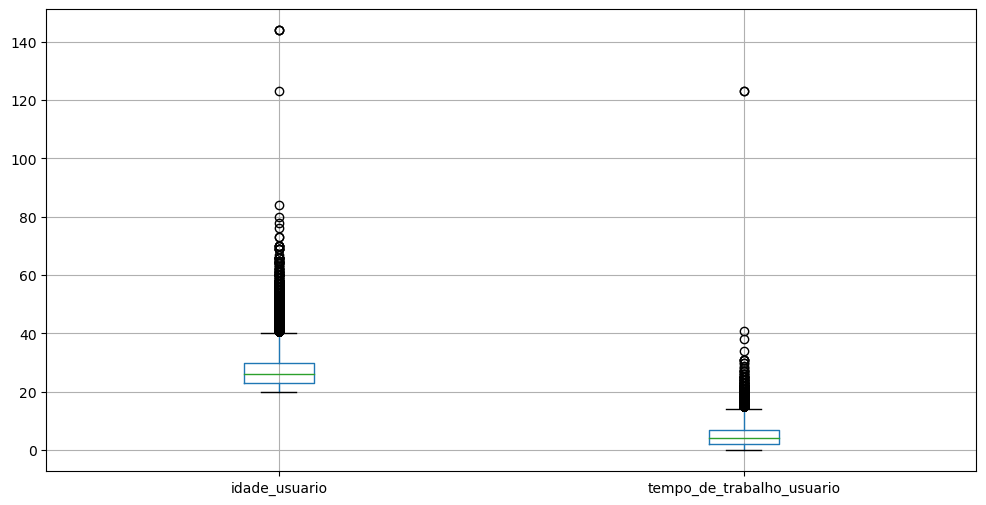

In [11]:
# BOXPLOT: Visualizando os dados de idade e tempo de trabalho
dados_tratados.boxplot(['idade_usuario', 'tempo_de_trabalho_usuario'])

In [12]:
# SUBSETING: Removendo dados com idade superior á 100 anos
dados_tratados = dados_tratados[(dados_tratados['idade_usuario'] < 100)]

In [13]:
# SUBSETING: Removendo dados com tempo de trabalho superior á 60 anos
dados_tratados = dados_tratados[dados_tratados['tempo_de_trabalho_usuario'] < 60 ]

<AxesSubplot:>

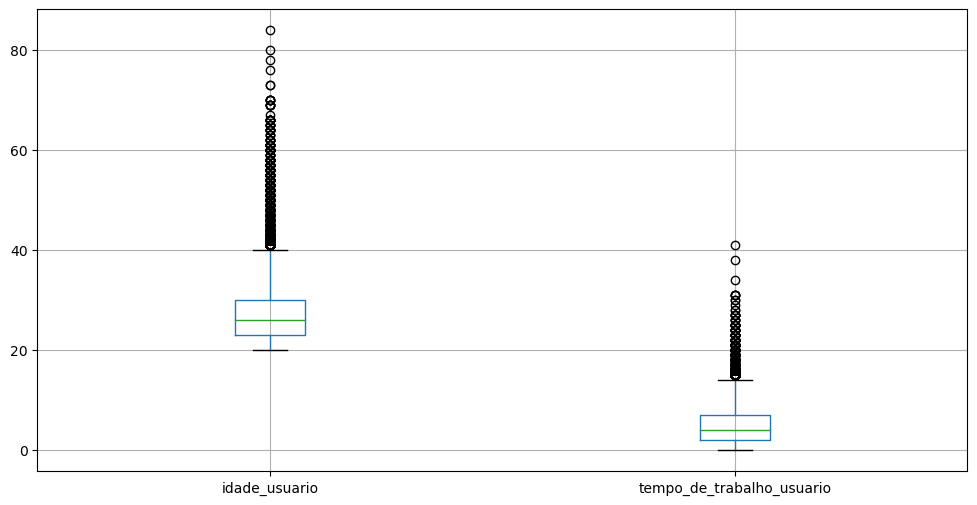

In [14]:
# BOXPLOT: Visualizando os dados após remoção
dados_tratados.boxplot(['idade_usuario', 'tempo_de_trabalho_usuario'])

<AxesSubplot:>

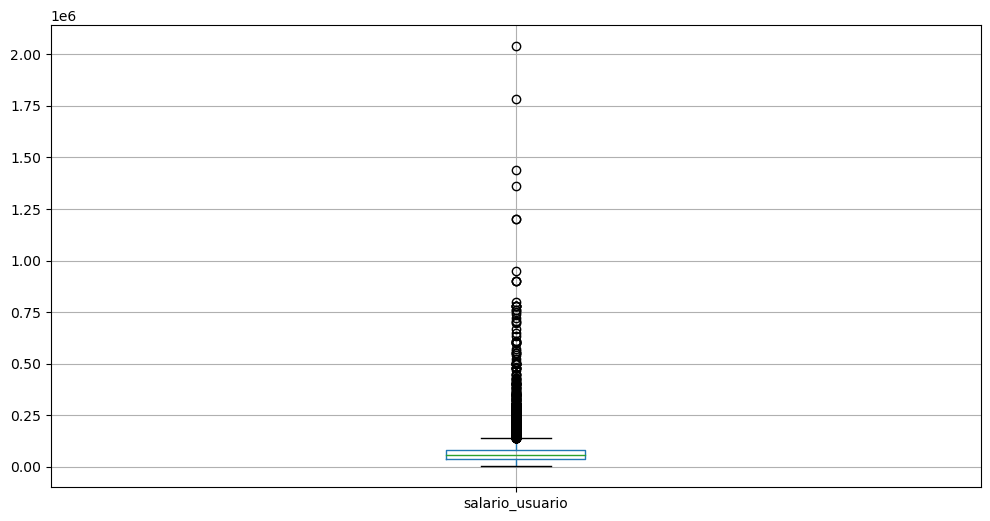

In [15]:
# BOXPLOT: Visualizando os dados de salário
dados_tratados.boxplot(['salario_usuario'])

In [16]:
# SUBSETING ROWS: Vamos listar estes salários acima de 1Mi para verificamos mais detalhes
dados_tratados[dados_tratados['salario_usuario'] > 1000000 ].head()

,idade_usuario,salario_usuario,situacao_moradia_usuario,tempo_de_trabalho_usuario,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,renda_percentual_emprestimo,devendo,tempo_de_credito
14717,32.0,1200000.0,Hipotecada,1.0,Empreendimento,A,12000.0,7.51,0.0,0.01,N,8.0
27729,42.0,2039784.0,Alugada,0.0,Empreendimento,C,8450.0,12.29,0.0,0.00,Y,15.0
32532,47.0,1362000.0,Hipotecada,9.0,Empreendimento,A,6600.0,7.74,0.0,0.00,N,17.0
32945,36.0,1200000.0,Propria,16.0,Medico,A,10000.0,6.54,0.0,0.01,N,11.0
34348,44.0,1440000.0,Hipotecada,7.0,Pagamento de Debitos,A,6400.0,7.40,0.0,0.00,N,15.0


NOTA: Obtivemos 4 registros de clientes que ganham acima de 1 milhão e verificando o valor de emprestimo solicitado, vemos valores entre muito baixo entre 6.6K á 12K para uma pessoa que ganha acima de 1 Mi USD, sendo assim, o time resolveu remover estes dados. 

In [17]:
# SUBSETING: Removendo dados com salários acima de 1 milhão
dados_tratados = dados_tratados[dados_tratados['salario_usuario'] < 1000000]

<AxesSubplot:>

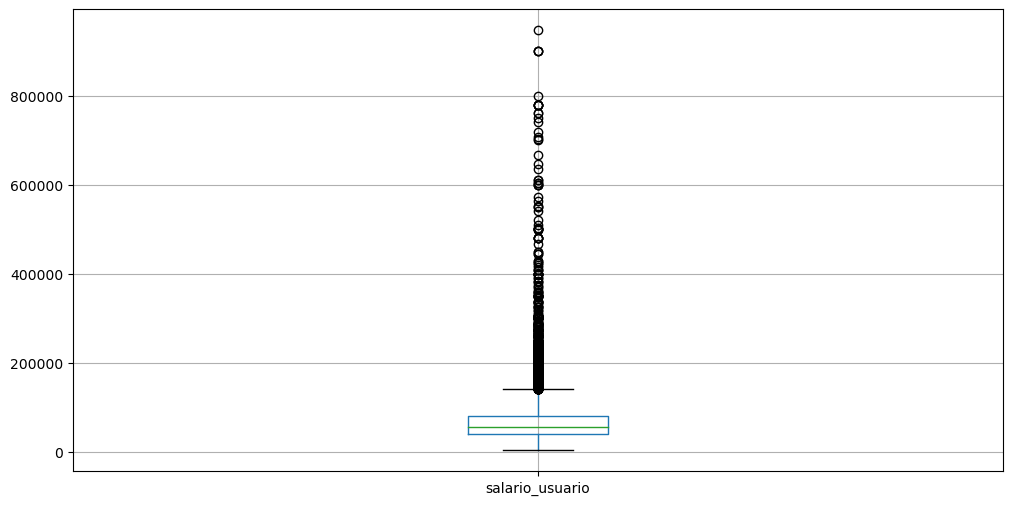

In [18]:
# BOXPLOT: Visualizando os dados de salário após remoção
dados_tratados.boxplot(['salario_usuario'])

### iii) Categorical Data Inconsistency

##### Verificando inconsistência nos dados categóricos

In [19]:
dados_tratados['situacao_moradia_usuario'].unique()

array(['Alugada', 'Hipotecada', 'Propria', 'Outros'], dtype=object)

In [20]:
dados_tratados['situacao_moradia_usuario'].unique()

array(['Alugada', 'Hipotecada', 'Propria', 'Outros'], dtype=object)

In [21]:
dados_tratados['motivo_emprestimo'].unique()

array(['Educativo', 'Medico', 'Empreendimento', 'Melhoria do Lar',
       'Pessoal', 'Pagamento de Debitos'], dtype=object)

In [22]:
dados_tratados['pontuacao_emprestimo'].unique()

array(['B', 'A', 'C', 'D', 'F', 'E', 'G'], dtype=object)

In [23]:
dados_tratados['status_emprestimo'].unique()

array([0., 1.])

In [24]:
dados_tratados['devendo'].unique()

array(['N', 'Y'], dtype=object)

### 2.4 DATA TYPES




In [25]:
# Verificando o tipo de dados
dados_tratados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28626 entries, 0 to 34500
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade_usuario                28626 non-null  float64
 1   salario_usuario              28626 non-null  float64
 2   situacao_moradia_usuario     28626 non-null  object 
 3   tempo_de_trabalho_usuario    28626 non-null  float64
 4   motivo_emprestimo            28626 non-null  object 
 5   pontuacao_emprestimo         28626 non-null  object 
 6   valor_emprestimo             28626 non-null  float64
 7   taxa_juros_emprestimo        28626 non-null  float64
 8   status_emprestimo            28626 non-null  float64
 9   renda_percentual_emprestimo  28626 non-null  float64
 10  devendo                      28626 non-null  object 
 11  tempo_de_credito             28626 non-null  float64
dtypes: float64(8), object(4)
memory usage: 2.8+ MB


Vamos alterar o tipo de dados conforme o dicionário de dados e em seguida resetar o index para ficar ordenado após a remoção dos dados

### i) Dtype

In [26]:
# Alteração do Dtype do tipo float64 para int64
dados_tratados['idade_usuario'] = dados_tratados['idade_usuario'].astype('int64')
dados_tratados['tempo_de_trabalho_usuario'] = dados_tratados['tempo_de_trabalho_usuario'].astype('int64')
dados_tratados['status_emprestimo'] = dados_tratados['status_emprestimo'].astype('int64')
dados_tratados['tempo_de_credito'] = dados_tratados['tempo_de_credito'].astype('int64')

### ii)  Reset Index

In [27]:
dados_tratados.index = range(dados_tratados.shape[0])
dados_tratados.index

RangeIndex(start=0, stop=28626, step=1)

In [28]:
# Imprimindo na tela informações do dataframe
n_linha_removidas =  dados.shape[0] - dados_tratados.shape[0]
p_linha_removidas = ((n_linha_removidas / dados.shape[0]) * 100)

print(f'Número de Registros Atual: {dados_tratados.shape[0]}')
print(f'Total de Registros removidos: {n_linha_removidas} / Percentual: {p_linha_removidas} %')

Número de Registros Atual: 28626
Total de Registros removidos: 5875 / Percentual: 17.028491927770208 %


### 2.5 EXPLORING DATA

Para a maioria dos modelos de risco de crédito, especialmente para probabilidade de inadimplência, colunas como tempo de trabalho do usuário e situação da moradia do usuário são comuns para começar a investigar.

Vamos verificar como nossa variável default (status do emprestimo) é afetado por fatores como:  `tempo_de_trabalho_usuario`, `situacao_moradia_usuario`, `pontuacao_emprestimo` a `renda_percentual_emprestimo`.

#### Hipóteses para serem validadas:
- H1: Existe diferença significativa nas médias do Tempo de Trabalho  por Status do Empréstimo? ***P-Value =0 >> Sim***
- H2: Existe diferença significativa na Renda Percentual Média por Status do Empréstimo? ***P-Value =0 >> Sim***
- H3: Existe diferença significativa no Tipo de Situação da Moradia por Status do Empréstimo?
- H4: Existe diferença significativa na  Pontução do Emprestimo por Status do Empréstimo?


### Qual o percentual de inadimplentes da base de dados ? 

In [97]:
# Verificando a taxa de inadimplentes
inadimplentes_perc = ((dados_tratados['status_emprestimo'].value_counts(normalize= True))*100).round(2)
inadimplentes_valor = dados_tratados['valor_emprestimo']                 
print('Percentual de Inadimplência (%):', inadimplentes_perc[1])

Percentual de Inadimplência (%): 21.67


### H1: Existe uma diferença significativa no Tempo de Trabalho  por Status do Empréstimo?


##### Verificando a Distribuição de Frequência

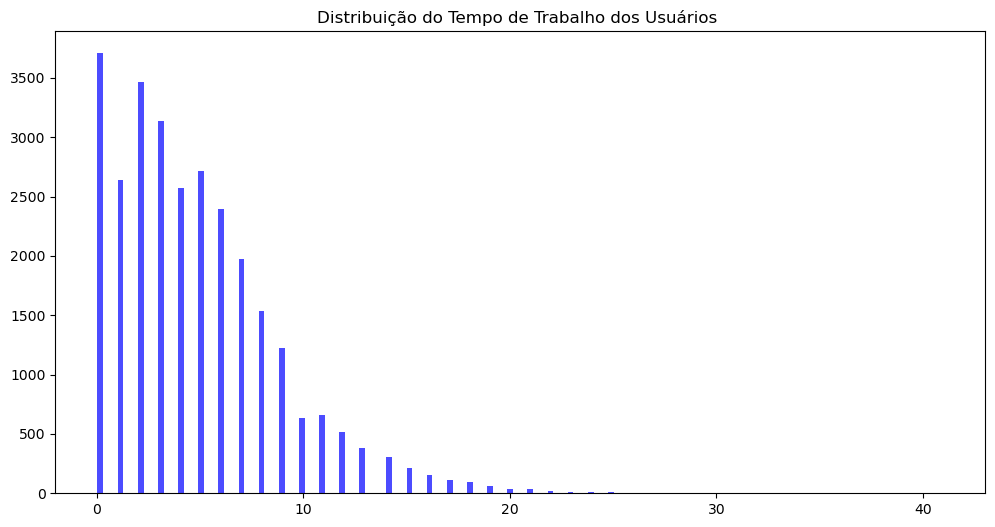

In [98]:
# Plotando Histograma
n, bins, patches = plt.hist(x=dados_tratados['tempo_de_trabalho_usuario'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.title('Distribuição do Tempo de Trabalho dos Usuários ')
plt.show()

##### Comparando o Tempo de Trabalho por Status de Empréstimo

<AxesSubplot:xlabel='tempo_de_trabalho_usuario', ylabel='status_emprestimo'>

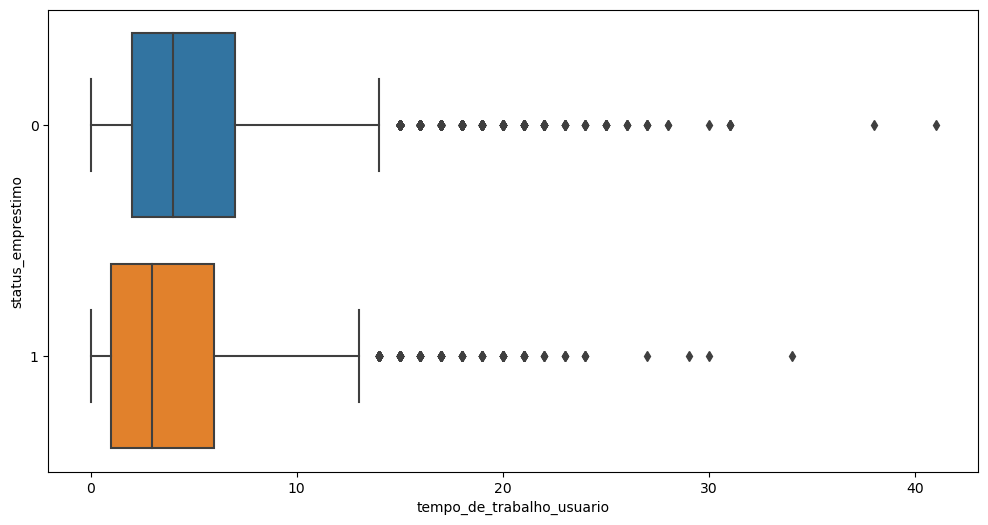

In [99]:
sns.boxplot(data = dados_tratados, y = 'status_emprestimo', x= 'tempo_de_trabalho_usuario', orient= 'h'  )

##### Validando Hipótese H1

In [100]:
# Subset por status do emprestimo
subset_inadimplentes = dados_tratados.query("status_emprestimo == 1")
subset_adimplentes = dados_tratados.query("status_emprestimo == 0")

In [101]:
from statsmodels.stats.weightstats import DescrStatsW

descr_tempo_trabalho_inadimplentes = DescrStatsW(subset_inadimplentes.tempo_de_trabalho_usuario)
descr_tempo_trabalho_adimplentes = DescrStatsW(subset_adimplentes.tempo_de_trabalho_usuario)

comparacao = descr_tempo_trabalho_inadimplentes.get_compare(descr_tempo_trabalho_adimplentes)
comparacao.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,-0.8465,0.058,-14.678,0.000,-0.960,-0.734


***Considerações:***
- O Tempo de Trabalho dos clientes estão concentrados abaixo de 10 anos, conforme a Distribuição de Frequência
- De acordo com ***p-value=0***, podemos dizer que estatisticamente  existe uma diferença significativa entre as médias das amostras, onde as pessoas inadimplentes possuem menos tempo de trabalho do que os Adimplentes.

### H2: Existe diferença significativa na Renda Percentual Média por Status do Empréstimo?

##### Verificando a Distribuição de Frequência

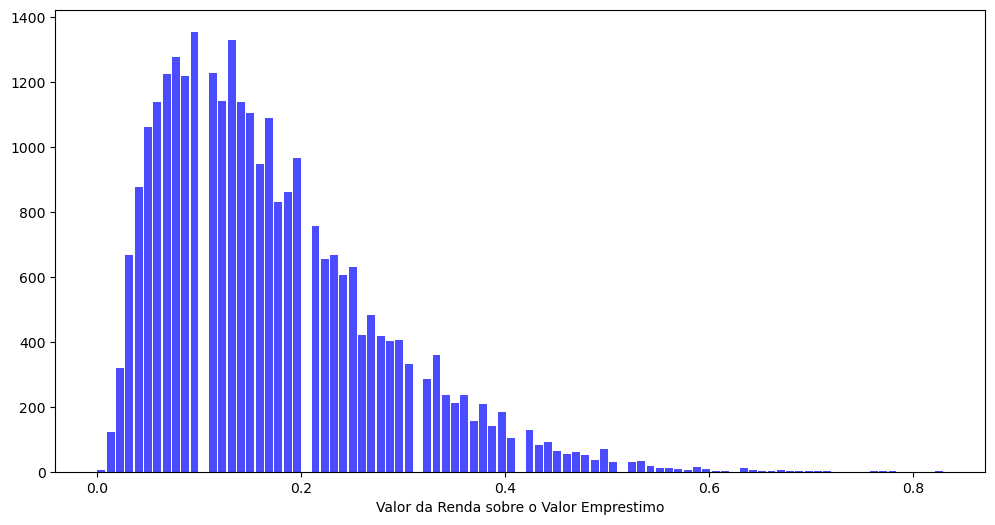

In [95]:
# Verificando a distribuição do valor de emprestimo com um histograma
n, bins, patches = plt.hist(x=dados_tratados['renda_percentual_emprestimo'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Valor da Renda sobre o Valor Emprestimo")
plt.show()

##### Comparando o Tempo de Trabalho por Status de Empréstimo

<AxesSubplot:xlabel='renda_percentual_emprestimo', ylabel='status_emprestimo'>

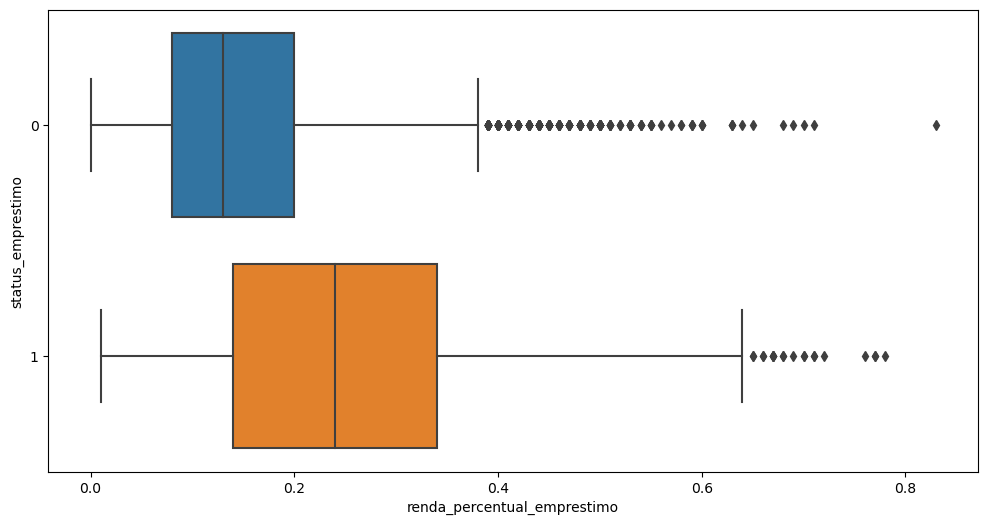

In [96]:
# Plotando o Boxplot
sns.boxplot(data = dados_tratados, y = 'status_emprestimo', x= 'renda_percentual_emprestimo', orient= 'h')

##### Validando Hipótese

In [102]:
from statsmodels.stats.weightstats import DescrStatsW

# Subset do percentual das rendas sobre status do emprestimo
descr_salario_inadimplentes = DescrStatsW(subset_inadimplentes.renda_percentual_emprestimo)
descr_salario_adimplentes = DescrStatsW(subset_adimplentes.renda_percentual_emprestimo)

comparacao = descr_salario_inadimplentes.get_compare(descr_salario_adimplentes)
comparacao.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,0.0980,0.001,69.391,0.000,0.095,0.101


#### Considerações:
- Podemos verificar que a maior parte dos emprestimos estão concentrados até 30% da renda sobre o valor total do empréstimo.
- As pessoas consideradas Inadimplentes obtiveram um valor maior da sua renda comprometida com o valor de emprestímo, ou seja, isso pode indicar que essas pessoas têm uma relação dívida/renda que já é muito alta.
- Essa conclusão pode ser comprovado com o ***p-value=0***, podemos dizer que estatisticamente existe uma diferença significativa entre as médias das amostras.

### H2: Existe diferença significativa no Tipo de Situação da Moradia por Status do Empréstimo?


Geralmente os dados financeiros são visualizados por meio de tabelas, sendo assim, vamos utilizar tabelas cruzadas para verificamos estas informações

##### Verificando os dados através de uma tabela cruzada

In [92]:
pd.crosstab(index=dados_tratados['situacao_moradia_usuario'], columns= dados_tratados['status_emprestimo'],
            values=dados_tratados['status_emprestimo'], aggfunc='count', margins= True ).round(2)

status_emprestimo,0,1,All
situacao_moradia_usuario,,,
Alugada,10002,4544,14546
Hipotecada,10310,1485,11795
Outros,67,27,94
Propria,2045,146,2191
All,22424,6202,28626


Como estamos comparando 2 variáveis categóricas não será possível neste momento de responder esta Hipótese.

### H3: Existe diferença significativa na  Pontução do Emprestimo por Status do Empréstimo?

##### Verificando os dados através de uma tabela cruzada

In [94]:
pd.crosstab(index=dados_tratados['pontuacao_emprestimo'], columns= dados_tratados['status_emprestimo'],
            values=dados_tratados['pontuacao_emprestimo'], aggfunc='count', margins= True ).round(2)

status_emprestimo,0,1,All
pontuacao_emprestimo,,,
A,8493,904,9397
B,7696,1453,9149
C,4538,1157,5695
D,1325,1922,3247
E,308,562,870
F,63,146,209
G,1,58,59
All,22424,6202,28626


Como estamos comparando 2 variáveis categóricas não será possível neste momento de responder esta Hipótese.

### Distribuição do valor de emprestimo

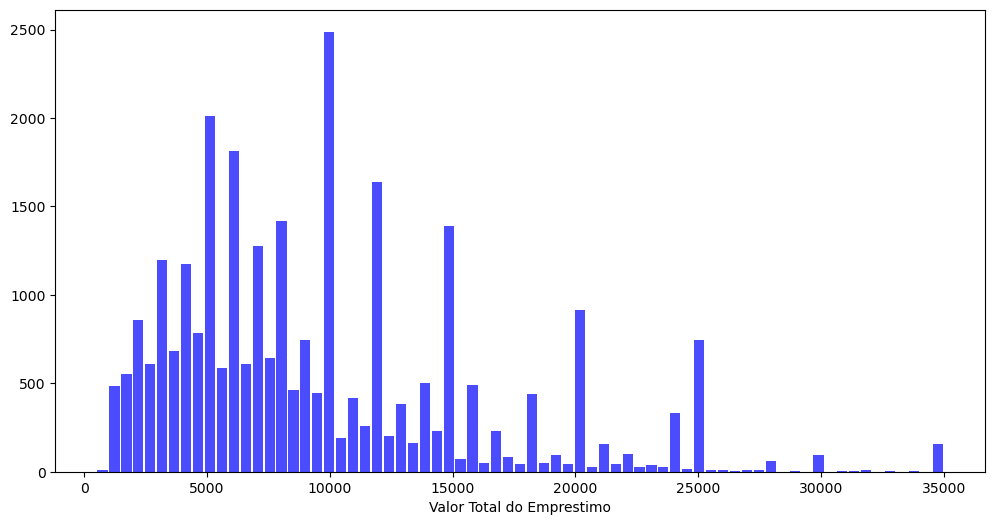

In [34]:
# Verificando a distribuição do valor de emprestimo com um histograma
n, bins, patches = plt.hist(x=dados_tratados['valor_emprestimo'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Valor Total do Emprestimo")
plt.show()

<AxesSubplot:xlabel='valor_emprestimo', ylabel='status_emprestimo'>

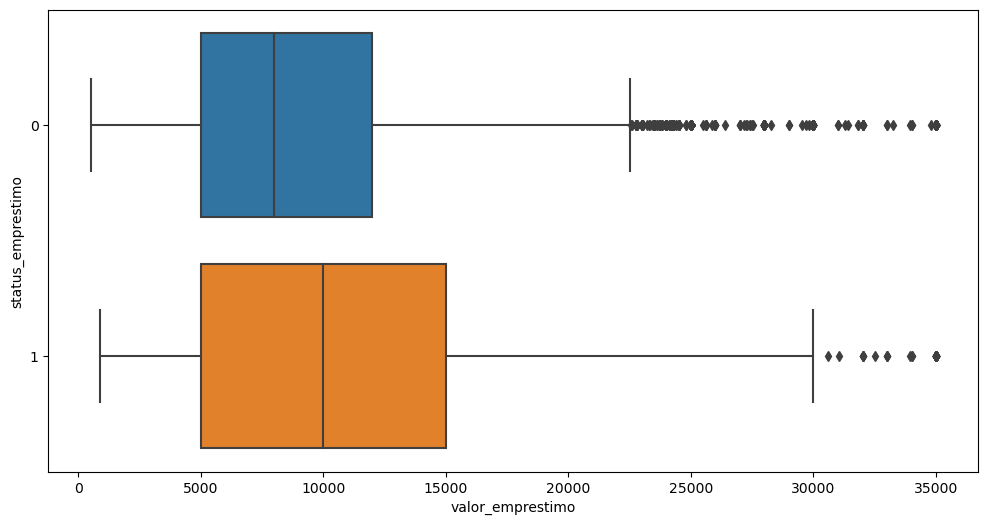

In [81]:
# Plotando o Boxplot
sns.boxplot(data = dados_tratados, y = 'status_emprestimo', x= 'valor_emprestimo', orient= 'h')

Podemos verificar que existe uma boa quantidade de empréstimos no valor de $ 10mil

### Verificando a relação entre as variáveis `idade_usuario` e `salario_usuario`

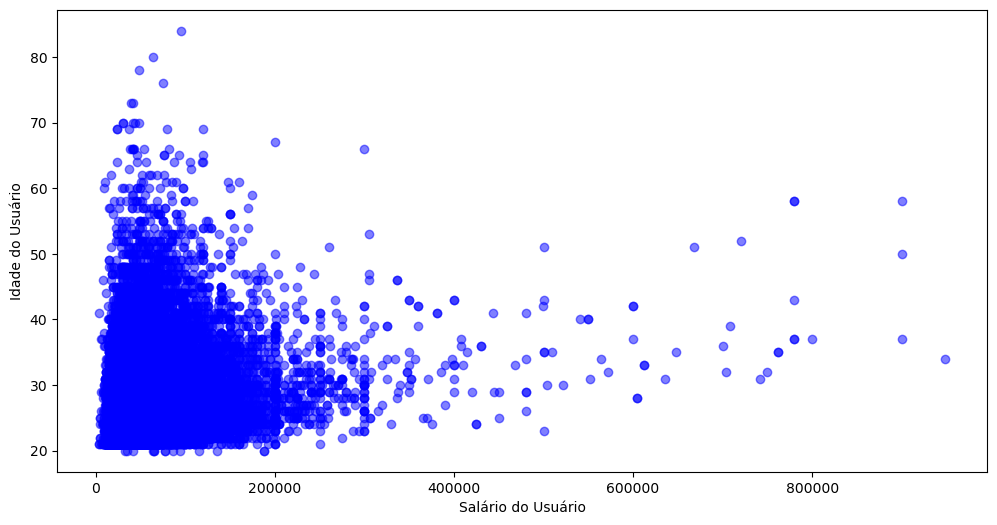

In [75]:
# Plotando um gráfico de dispersão entre a idade e o salário do usuário
plt.scatter(x = dados_tratados['salario_usuario'], y = dados_tratados['idade_usuario'], c ='blue', alpha = 0.5)
plt.xlabel('Salário do Usuário')
plt.ylabel('Idade do Usuário')
plt.show()

> Já podemos ver uma correlação positiva com idade e renda, o que pode significar que essas pessoas mais velhos estão mais avançados em suas carreiras e, portanto, ganham salários mais altos.